### Load the data

In [1]:
import pandas as pd

df = pd.read_csv('data/student_data.csv')
df.head()

,height,weight,BMI,level,faculty,department,dob,GPA,gender,age,study_hours,WASSCE_Aggregate
0,154,89,37.5,300,Faculty of Business,Accounting,2006-08-02,1.74,Male,19,9.8,35
1,187,88,25.2,300,Faculty of Engineering,Mechanical,1999-04-13,2.43,Female,26,9.3,25
2,189,82,23.0,200,Faculty of Engineering,Mechanical,2002-06-08,2.89,Male,23,1.6,15
3,193,92,24.7,200,Faculty of Theology,Pastoral Studies,2005-07-31,3.93,Female,20,9.0,21
4,184,89,26.3,400,Faculty of Computing,Software Engineering,2002-09-01,1.89,Male,23,7.1,7


### Check for missing data

In [2]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   height            500 non-null    int64  
 1   weight            500 non-null    int64  
 2   BMI               500 non-null    float64
 3   level             500 non-null    int64  
 4   faculty           500 non-null    object 
 5   department        500 non-null    object 
 6   dob               500 non-null    object 
 7   GPA               500 non-null    float64
 8   gender            500 non-null    object 
 9   age               500 non-null    int64  
 10  study_hours       500 non-null    float64
 11  WASSCE_Aggregate  500 non-null    int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 47.0+ KB


height              0
weight              0
BMI                 0
level               0
faculty             0
department          0
dob                 0
GPA                 0
gender              0
age                 0
study_hours         0
WASSCE_Aggregate    0
dtype: int64

Data Cleaning & Transformation

In [3]:
df = df.dropna()  # or use fillna() if appropriate

#### Convert DOB to Age

In [4]:
from datetime import datetime
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['age'] = datetime.now().year - df['dob'].dt.year


### Compute BMI (if not pre-calculated)

In [5]:
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2


Encode Categorical Variables

In [6]:
df = pd.get_dummies(df, columns=['faculty', 'department', 'gender', 'level'], drop_first=True)

## Exploratory Data Analysis (EDA)

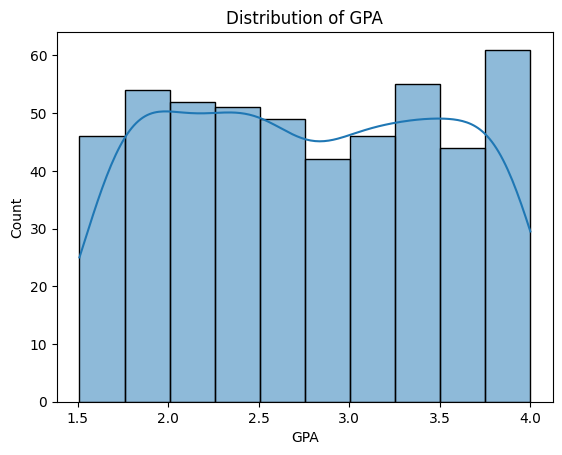

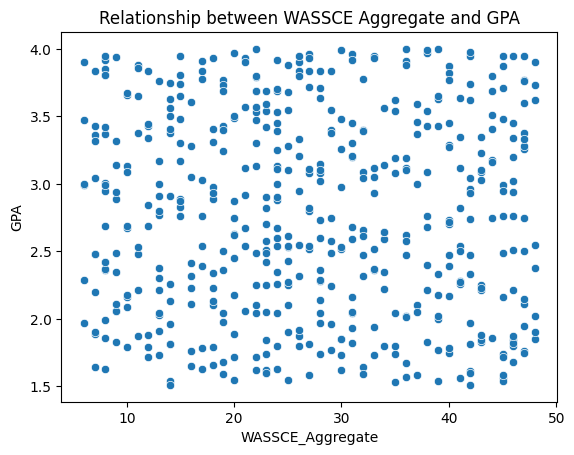

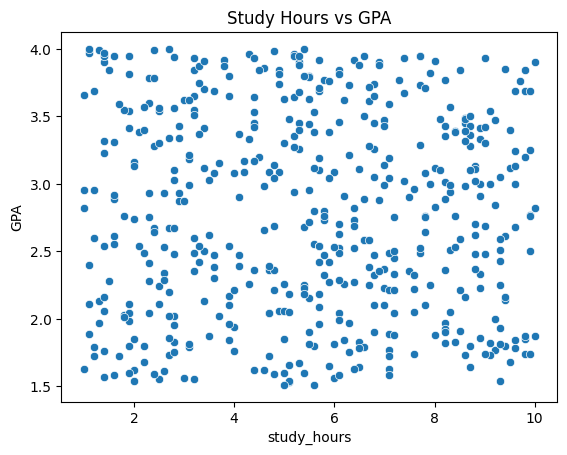

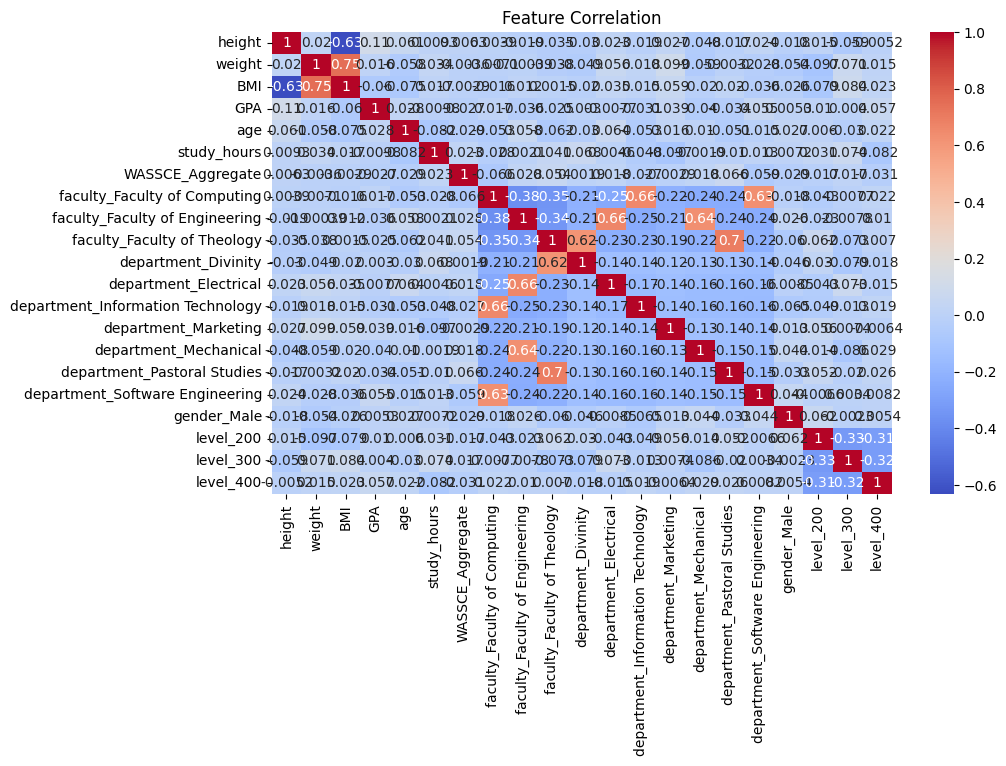

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# GPA distribution
sns.histplot(df['GPA'], kde=True)
plt.title('Distribution of GPA')
plt.show()

# WASSCE vs GPA
sns.scatterplot(x='WASSCE_Aggregate', y='GPA', data=df)
plt.title('Relationship between WASSCE Aggregate and GPA')
plt.show()

# Study hours vs GPA
sns.scatterplot(x='study_hours', y='GPA', data=df)
plt.title('Study Hours vs GPA')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()


## Feature Engineering

In [8]:
from sklearn.preprocessing import StandardScaler

# Numeric features to scale
features_num = ['height', 'weight', 'BMI', 'age', 'study_hours', 'WASSCE_Aggregate']
# One-hot encoded categorical feature columns
cat_cols = [col for col in df.columns if col.startswith(('faculty_', 'department_', 'gender_', 'level_'))]

# Prepare Linear Regression dataset
X_lr = df[features_num + cat_cols].copy()
y_lr = df['GPA'].copy()

# Scale only numeric features
scaler = StandardScaler()
X_lr[features_num] = scaler.fit_transform(X_lr[features_num])


## Linear Regression (Predict GPA)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


R² Score: -0.05194555447214655
MSE: 0.5889708089680356


### Visualize predictions

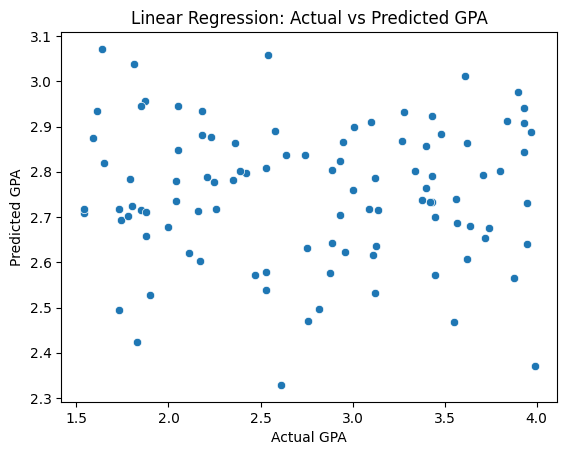

In [10]:
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual GPA")
plt.ylabel("Predicted GPA")
plt.title("Linear Regression: Actual vs Predicted GPA")
plt.show()

## Logistic regression

In [11]:
df['High_GPA'] = (df['GPA'] >= 3.0).astype(int)  # 1 = Good, 0 = Low

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Build a numeric-only feature matrix for classification (drop datetime like 'dob')
X_log = df.drop(['GPA', 'High_GPA'], axis=1)
X_log = X_log.select_dtypes(include='number')
y_log = df['High_GPA']

X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.55
[[54  3]
 [42  1]]
              precision    recall  f1-score   support

           0       0.56      0.95      0.71        57
           1       0.25      0.02      0.04        43

    accuracy                           0.55       100
   macro avg       0.41      0.49      0.37       100
weighted avg       0.43      0.55      0.42       100



## Feature Importance (Prediction Index)

In [12]:
importance = pd.DataFrame({
    'Feature': X_lr.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', ascending=False)
importance.head(10)


,Feature,Coefficient
19,level_400,0.261813
18,level_300,0.215667
17,level_200,0.170875
1,weight,0.148441
9,department_Divinity,0.039651
15,department_Software Engineering,0.033677
10,department_Electrical,0.025163
4,study_hours,0.011595
12,department_Marketing,0.011554
3,age,0.007472


#### Linear Regression Coefficients:


In [13]:
importance = pd.DataFrame({
    'Feature': X_lr.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', ascending=False)
importance.head(10)


,Feature,Coefficient
19,level_400,0.261813
18,level_300,0.215667
17,level_200,0.170875
1,weight,0.148441
9,department_Divinity,0.039651
15,department_Software Engineering,0.033677
10,department_Electrical,0.025163
4,study_hours,0.011595
12,department_Marketing,0.011554
3,age,0.007472


#### Logistic Regression:

In [14]:
importance_log = pd.DataFrame({
    'Feature': X_log.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
importance_log.head(10)


,Feature,Coefficient
2,BMI,0.112045
0,height,0.039817
3,age,0.023188
4,study_hours,0.018629
5,WASSCE_Aggregate,0.001465
1,weight,-0.029772


Dashboard / Visualization